In this notebook we are going to implement some baseline algorithms for oferring recommendations to individual users.

As mentioned in the data document, we are going to start by implementing "basic.Popular" from the Lenskit library.

The mentioned algorithm will recommend the items, movie in this case, ordered by popularity. 

First, we will import the required libraries for Lenskit

In [34]:
import numpy as np
from lenskit import batch, crossfold
from lenskit.algorithms import Recommender, bias, basic, item_knn
from lenskit.metrics.predict import rmse, user_metric
from lenskit.algorithms import basic
from sklearn.metrics import mean_absolute_error



Now we will upload the pre-processed data from the previous notebook we created. 

In [35]:
import pandas as pd
preprocessed_dataset_folder = "../Data/PreprocessedDataset"
ratings_df = pd.read_csv(preprocessed_dataset_folder+"/ratings.csv")
display(ratings_df.head(10))


,user,item,rating,timestamp
0,17783,5954,5.0,1288572640
1,147353,2805,2.0,979368264
2,32778,1982,4.0,1559214270
3,17160,1225,4.5,1151466878
4,58005,6537,3.0,1112739432
5,133040,736,2.0,1076959711
6,73670,4975,2.0,1415292692
7,118041,1248,4.5,1522631138
8,73268,122904,0.5,1475355740
9,133495,1388,1.0,991281570


What are the pros and cons of the first baseline, on our MovieLens dataset?

-it is a basic algorithm, easy to scale for a big dataset like ours, even if we use small samples 

-will be our first comparison point to more advanced soltuions 

-it s a non personalized algorithm so unfortunetally will not take into consideration users prefferences, but will be 

interesing to compare with peronalized baselines. 

In [5]:
popular_recommender = Recommender.adapt(basic.Popular()) 

For splitting our data into test and train sets we will use the K-fold cross validation. 

This has the advantage of evaluating the algorithm on different subsets of the data each time so we can have a better conclusion how it performs on different unseen data sets.

We experimented using different values for the number of folds (3,5,7,9) to see which one will obtain the lowest root mean squared error. 

Now we will train our algorithm on the k-1 folds and test on the k last fold. 
We will experiment which number of folds gives us most reliable results. We will be looking for one which has more stratified folds
i.e. which has lower deviation beetwen values of rmse for each fold.

In [11]:
import numpy as np
import matplotlib.pyplot as plt

rmse_values = []

for k in range(3, 10, 2):
        
        total_rmse = 0
        total_mae = 0
        splits = crossfold.partition_users(ratings_df, k, crossfold.SampleFrac(1.0/k))
        fold_rmse_values = []
        
        for i, (train, test) in enumerate(splits):
                #copy our splits to not modify the data
                train_ratings = train.copy()
                test_ratings = test.copy()

                #fit the popular model
                popular_recommender.fit(train_ratings)
                
                users = test_ratings['user'].unique()
                recommendations = batch.recommend(popular_recommender, users, 10)
                min_score = recommendations['score'].min()
                max_score = recommendations['score'].max()

                recommendations['score'] = 5 * (recommendations['score'] - min_score) / (max_score - min_score) # to set ratings between 0 and 5
        
                #we evaluate the recoomendations comparing the ratings with our predictions
                test_pred = pd.merge(test_ratings[['user', 'item', 'rating']], recommendations, on=['user', 'item'])
                test_rmse = rmse(test_pred['rating'], test_pred['score'])
                fold_rmse_values.append(test_rmse)
                test_mae = mean_absolute_error(test_pred['rating'], test_pred['score'])
        
                total_rmse += test_rmse/k
                total_mae += test_mae/k
        rmse_values.append(fold_rmse_values)
        print(f'Number of folds {k} RMSE: {total_rmse:.2f}, MAE: {total_mae:.2f}')

Number of folds 3 RMSE: 2.56, MAE: 2.27
Number of folds 5 RMSE: 2.68, MAE: 2.39
Number of folds 7 RMSE: 2.82, MAE: 2.50
Number of folds 9 RMSE: 2.69, MAE: 2.35


From the graph bellow we can see that eventhough when number of folds is equal to 7 we get highest mean rmse score, we can see that deviation of fold is the smallest and it is most probable that in that case we get more stratified folds. Note: I run multiple times this experiment and in each of them I get same results that 7 folds is best.

So we can conclude that basic.Popular recommender on this dataset gives RMSE = 2.82 and MAE = 2.50

In [27]:
average_rmse = 2.82
average_mae = 2.50

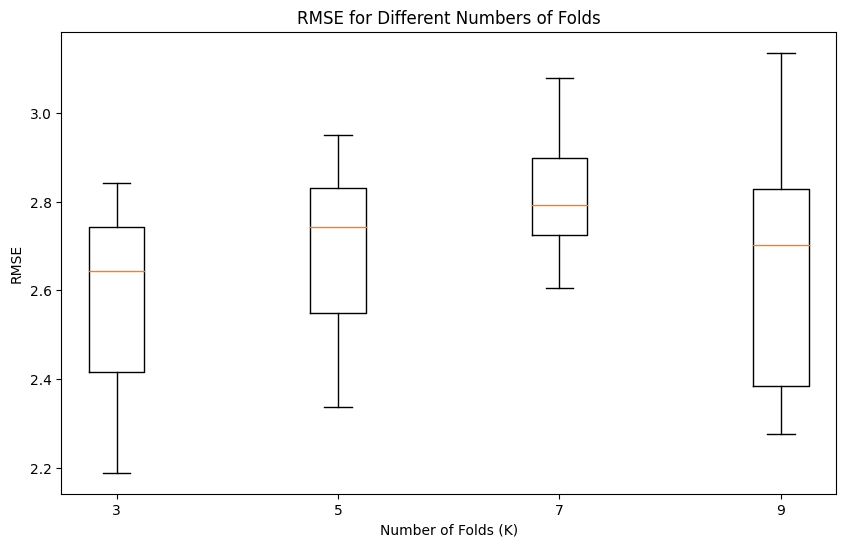

In [14]:
plt.figure(figsize=(10, 6))
plt.boxplot(rmse_values, positions=np.arange(3, 10, 2))
plt.xlabel('Number of Folds (K)')
plt.ylabel('RMSE')
plt.title('RMSE for Different Numbers of Folds')
plt.xticks(ticks=np.arange(3, 10, 2), labels=[str(i) for i in range(3, 10, 2)])
plt.show()

Now we will implement another baseline in order to compare with the popularity one, which did not performed that good.

 The results will be compared and disussed later. The new baseline we will implement is BiasOnly model.
 
The pros and cons for this algorithm and why we chose it are:

-as being simple algorithm, is again suitable for large and sparse datasets as our 

-in comparison with the popularity one this is personalized taking into account item and user biases



In [20]:
bias_recommender = Recommender.adapt(bias.Bias())

We will use the same k fold cross validation explained above with only 7 folds as provided the best results. We also need to keep the same evaluation structure for the sake of comparison. The code will remain the same, as explained above. 

In [24]:
splits = crossfold.partition_users(ratings_df, 7, crossfold.SampleFrac(1.0/7))
media_rmse_2 = 0
media_mae_2 = 0
for i, (train, test) in enumerate(splits):
        #copy our splits to not modify the data
        train_ratings2 = train.copy()
        test_ratings2 = test.copy()

       #fit the popular model
        bias_recommender.fit(train_ratings2)
        
        users2 = test_ratings2['user'].unique()
        recommendations2 = batch.recommend(bias_recommender, users2, 10)
        min_score2 = recommendations2['score'].min()
        max_score2 = recommendations2['score'].max()


        recommendations2['score'] = 5 * (recommendations2['score'] - min_score2) / (max_score2 - min_score2)

        #we evsaluate the recoomendations ccomparing the ratings with our predictions
        test_pred2 = pd.merge(test_ratings2[['user', 'item', 'rating']], recommendations2, on=['user', 'item'])
        test_rmse2 = rmse(test_pred2['rating'], test_pred2['score'])
        test_mae2 = mean_absolute_error(test_pred2['rating'], test_pred2['score'])

        media_rmse_2 = media_rmse_2 +test_rmse2
        media_mae_2 = media_mae_2 + test_mae2
        print(f'Split {i + 1} RMSE: {test_rmse2:.2f}, MAE: {test_mae2:.2f}')
        
average_rmse_2 = media_rmse_2 / 7 
print(f'Average RMSE over all splits for Bias algo : {average_rmse_2:.2f}')
average_mae_2 = media_mae_2 / 7
print(f'Average MAE over all splits: {average_mae_2:.2f}')

Split 1 RMSE: 1.48, MAE: 1.27
Split 2 RMSE: 1.73, MAE: 1.53
Split 3 RMSE: 1.49, MAE: 1.33
Split 4 RMSE: 1.27, MAE: 1.04
Split 5 RMSE: 1.95, MAE: 1.69
Split 6 RMSE: 1.07, MAE: 0.85
Split 7 RMSE: 1.99, MAE: 1.81
Average RMSE over all splits for Bias algo : 1.57
Average MAE over all splits: 1.36


Now let's combine the two created baselines and use the fallback algorithm which will take as parameters both the Popularity and Bias algorithms.

 The idea here is that we will use our Bias algorithm first and if it fails to generate recommendations, the fallback method will then use Popularity algorithm.
 
  In such case recommendations might be combined so we will expect better diversity and at the end, basically better results. We will see if this hypothesis holds.

The fallback method will have increased complexity but this is fine as we only work with a small sample od the data.

For the sake of comparison, the k-fold cross validation will stay the same as disucssed above. 

One advantage of adding popularity as a fallback to bias might be "the cold start problem". On the other hand, we might be more prone to overfitting so it can in some situations obtain a larger error. 

In [47]:
#our previous baselines we will use for the fallback 
algorithms = [bias_recommender, popular_recommender] 
fallback_recommender = basic.Fallback(algorithms)
candidate_selector = basic.UnratedItemCandidateSelector()
fallback_recommender.selector = candidate_selector


In [74]:
splits = crossfold.partition_users(ratings_df, 7, crossfold.SampleFrac(1.0/7))
media_rmse_3 = 0
media_mae_3 = 0
for i, (train, test) in enumerate(splits):
        #copy our splits to not modify the data
        train_ratings3 = train.copy()
        test_ratings3 = test.copy()

        #fit the popular model
        fallback_recommender.fit(train_ratings3)

        users3 = test_ratings3['user'].unique()
        recommendations3 = batch.predict(fallback_recommender, test_ratings3).sort_values(by='prediction', ascending=False).groupby('user').head(10)
        min_score3 = recommendations3['prediction'].min()
        max_score3 = recommendations3['prediction'].max()

        #we had to scale the recommendation score to match with the grading criteria between 0 and 5. 
        #for examples the scores generated were between 108 and 132.
        recommendations3['prediction'] = 5 * (recommendations3['prediction'] - min_score3) / (max_score3 - min_score3)
        test_rmse3 = rmse(recommendations3['rating'], recommendations3['prediction'])
        test_mae3 = mean_absolute_error(recommendations3['rating'], recommendations3['prediction'])
        media_rmse_3 = media_rmse_3 +test_rmse3
        media_mae_3 = media_mae_3 + test_mae3
        print(f'Split {i + 1} RMSE: {test_rmse3:.2f}, MAE: {test_mae3:.2f}')
    


average_rmse_3 = media_rmse_3 / 7
print(f'Average RMSE over all splits for Fallback algo : {average_rmse_3:.2f}')
average_mae_3 = media_mae_3 / 7  # Assuming to have 7 splits
print(f'Average MAE over all splits: {average_mae_3:.2f}')


Split 1 RMSE: 1.11, MAE: 0.90
Split 2 RMSE: 0.89, MAE: 0.70
Split 3 RMSE: 0.98, MAE: 0.77
Split 4 RMSE: 0.98, MAE: 0.79
Split 5 RMSE: 1.39, MAE: 1.18
Split 6 RMSE: 0.95, MAE: 0.75
Split 7 RMSE: 1.05, MAE: 0.85
Average RMSE over all splits for Fallback algo : 1.05
Average MAE over all splits: 0.85


Now let's plot the results of the two algorithms and try to compare them based on RMSE and MAE. Why do we use RMSE and MAE?

-Lenskit prvoides both of them, easy to implemenet and understand

-both evaluation methods are sensible to data sampleing, what we also did with our large dataset

-RMSE is more sensible to outliers so is not that good for very sparse samples. We show our data is not that sparse and this should not represent a big problem 


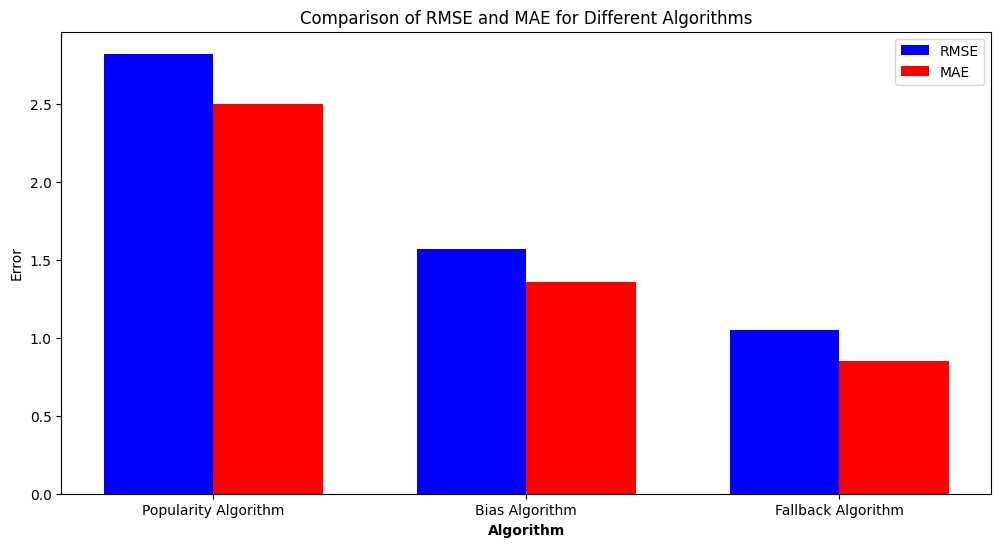

In [75]:

algorithms = ['Popularity Algorithm', 'Bias Algorithm', 'Fallback Algorithm']
rmse_values = [average_rmse, average_rmse_2, average_rmse_3]
mae_values = [average_mae, average_mae_2, average_mae_3]


bar_width = 0.35


r1 = np.arange(len(algorithms))
r2 = [x + bar_width for x in r1]
plt.figure(figsize=(12, 6))
plt.bar(r1, rmse_values, width=bar_width, color='b', label='RMSE')
plt.bar(r2, mae_values, width=bar_width, color='r', label='MAE')

plt.xlabel('Algorithm', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(algorithms))], algorithms)
plt.ylabel('Error')
plt.title('Comparison of RMSE and MAE for Different Algorithms')
plt.legend()

plt.show()


From these results we can conclude that Bias algorithm outperforms Popularity on both RMSE and MAE evaluation. This can be due to several reasons but I think main ones are that Bias is more complex algorithm than Popularity and the most important reason is that Bias-based algorithms take into account individual user preferences and item biases, allowing for personalized recommendations. These algorithms capture nuances in user behavior, leading to more accurate and tailored suggestions for users. Fallback algorithm performs the best as expected because it uses both popularity and bias algorithms in optimized way. On both MAE and RMSE outperforms other 2.

From now on, we will compare Fallback algorithm as the best baseline against other algorithms such as collaborative filtering and content based recommenders. Bellow are top 10 recommendation made by Fallback recommender.

In [78]:
recommendations_all = batch.predict(fallback_recommender, ratings_df).sort_values(by='prediction', ascending=False).groupby('user').head(10)
min_score_all = recommendations_all['prediction'].min()
max_score_all = recommendations_all['prediction'].max()
recommendations_all['prediction'] = 5 * (recommendations_all['prediction'] - min_score_all) / (max_score_all - min_score_all)
print(recommendations_all.head(10))

         user    item  rating   timestamp  prediction
5840   129440     296     5.0  1463341622    5.000000
26945  129440     589     5.0  1463363392    4.864211
50766  129440    1089     5.0  1463341674    4.857005
14677  129440    1270     5.0  1463342235    4.804002
62998  129440     923     5.0  1522096214    4.791878
40861  129440    1090     5.0  1463363661    4.695384
27227  129440    6377     5.0  1463342304    4.683654
58562  129440     356     5.0  1463341613    4.637652
44863  129440  122882     5.0  1463341628    4.506796
2736   129440    3499     5.0  1463364005    4.503890
